In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')

# Power spectra of radial velocity for the F series of runs (derived from RProfile data)

In [31]:
import os.path
import os
import sys

cwd = os.getcwd()
sys.path.insert(0, '/rpod2/home/andrassy/notebooks/lib/lcse')
import rprofile
import ppm
import numpy as np
import matplotlib.pyplot as pl
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
from matplotlib import gridspec
%matplotlib nbagg
from pyshtools.expand import SHExpandLSQ
from pyshtools.expand import MakeGridDH
from pyshtools.spectralanalysis import spectrum

In [87]:
def get_power_spectrum_RProfile(yprof_path, rprof_path, r0, t_lim=None, t_res=None, l_max=6):
    '''
    Calculates power spectra of radial velocity
    
    Parameters
    ----------
    yprof_path/rprof_path: strings
        paths for matching rprofile and yprofile files
    r0: float
        radius to examine
    t_lim: 2 index array
        [t_min, t_max], data to look at
    t_res: int
        set number of data points between [t_min, t_max], None = ndumps
    l_max:
        maximum spherical harmonic degree l
        
    Output
    ------
    t,l,power : time, spherical harmonic degree l, and power vectors
    '''
    yprof = ppm.yprofile(yprof_path, filename_offset=-1)
    n_buckets = 80
    rp_set = rprofile.rprofile_set(rprof_path)
    n_dumps = rp_set.dumps[-1]
        
    if t_lim is None:
        t_min = rp_set.get_dump(1).get('time')
        t_max = rp_set.get_dump(n_dumps).get('time')
        t_lim = [t_min, t_max]

    if t_res is None:
        t_res = n_dumps
        
    t = np.linspace(t_lim[0], t_lim[1], t_res)
    
    l = np.arange(0, l_max + 1)
    power = np.zeros((len(t), l_max + 1))
    
    for i in range(len(t)):
        dump = int(yprof.get('Ndump', fname=t[i], numtype='t', silent=True)[-1])
        if dump > n_dumps:
            dump = n_dumps
        rp = rp_set.get_dump(dump)
        r = rp.get_table('y')
        idx0 = np.argmin(np.abs(r - r0))
        
        vx = rp.get_table('ux')
        vy = rp.get_table('uy')
        vz = rp.get_table('uz')
        centers = rp.get_centers()
    
        lat = np.zeros(n_buckets)
        lon = np.zeros(n_buckets)
        vr = np.zeros(n_buckets)
        for bucket in range(n_buckets):
            x = centers[0, bucket]
            y = centers[1, bucket]
            z = centers[2, bucket]
            bucket_r = (x**2 + y**2 + z**2)**0.5
            lat[bucket] = 90. - (180./np.pi)*np.arccos(z/bucket_r)
            lon[bucket] = (180./np.pi)*np.arctan2(y, x)

            r_norm = np.array([x, y, z])/bucket_r
            v = np.array([vx[0, idx0, bucket+1], \
                          vy[0, idx0, bucket+1], \
                          vz[0, idx0, bucket+1]])
            vr[bucket] = np.dot(v, r_norm)
        
        coeffs, _ = SHExpandLSQ(vr, lat, lon, l_max)
        power[i, :] = spectrum(coeffs, convention='power', unit='per_l')

    return t, l, power

def plot_power_spectrum_RProfile(t, l, power, ifig=1, title='', vmin=1e-2, vmax=1.):
    '''
    Plots power spectra of radial velocity 
    
    Parameters
    ----------
    t,l,power : arrays
        time, sperical harmonic degree and power generated by
        get_power_spectrum_RProfile()
    title : string
        title
    '''
    ifig = ifig; pl.close(ifig); pl.figure(ifig, figsize=(8., 5.), dpi=125)
    extent = (t[0]/60., t[-1]/60., l[0] - 0.5, l[-1] + 0.5)
    aspect = 0.5*(extent[1] - extent[0])/(extent[3] - extent[2]) 
    max_power = np.max(power)
    norm = LogNorm(vmin=vmin*max_power, vmax=vmax*max_power, clip=True)
    #norm = Normalize(vmin=0., vmax=max_power, clip=True)
    pl.imshow(np.transpose(np.abs(power)), origin='lower', extent=extent, aspect=aspect, \
               interpolation='nearest', norm=norm, cmap='viridis')
    cb = pl.colorbar()
    cb.set_label('m$^2$ (s$^2$ l)$^{-1}$')
    pl.xlabel('t / min')
    pl.ylabel('l')
    pl.title(title, y=1.025)
    ax0= pl.gca()
    ax0.get_yaxis().set_tick_params(direction='out')
    ax0.get_xaxis().set_tick_params(direction='out')

In [44]:
#def vr_spectra
#runs = ('F4', 'F4')
r0 = 26.0
t = {}
l = {}
power = {}
rn = 'F4'
#for rn in runs:
t[rn], l[rn], power[rn] = get_power_spectrum_RProfile(\
                          '/rpod2/PPM/YProfiles/AGBTP_M2.0Z1.e-5/{:s}'.format(rn), \
                          '/rpod2/PPM/RProfiles/AGBTP_M2.0Z1.e-5/{:s}'.format(rn), r0, t_res = 100)

Reading attributes from file  YProfile-01-1959.bobaaa
Analyzing headers ...
There are 1960 YProfile files in the /rpod2/PPM/YProfiles/AGBTP_M2.0Z1.e-5/F4 directory.
Ndump values range from 1 to 1960
Time values range from 86.5493 to 162264.0


<IPython.core.display.Javascript object>


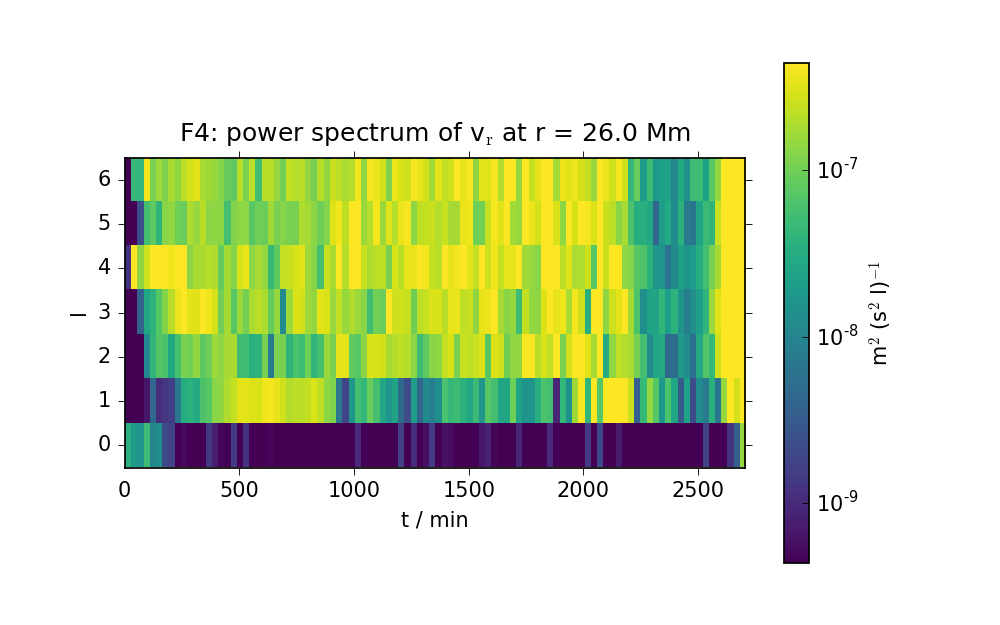

In [88]:
i = 0
#for rn in runs:
plot_power_spectrum(t[rn], l[rn], power[rn], ifig=i, \
                    title=r'{:s}: power spectrum of v$_\mathrm{{r}}$ at r = {:.1f} Mm'.\
                    format(rn, r0), vmin=1e-5, vmax=1e-2)
i += 1